# Project: Investigate alcohol consumption
## Table of contents
 - <a href="#intro">Introduction</a>
 - <a href="#wrangle">Data wrangling and cleaning</a>
 - <a href="#explore">Exploratory analysis</a>
 - <a href="#discussion">Discussion</a>

<a id="intro"></a>
## Introduction

For my analysis project, I choose the *"Gapminder World"* dataset. After I looked through the available variables, I chose *"Alcohol consumption per adult"* indicator as the dependent variable and the following three as the independent variable: 

 - *"Prevalence of current tobacco use among adults (>=15 years) (%, both sexes)"*
 - *"Income per person (fixed 2000 US$)"*
 - *"Total 15+ unemployed (%)"*

After the initial examination, I found that the matrix of measurements are extremely sparse, but the column for 2005 was quite filled, so I decided to take only this year into account.

Using these variables, I decided to answer this three questions:

 1. "How does the economy of a country relate to alcohol consumption?"
 2. "Is there any connection between addiction to alcohol and tobacco?"
 3. "Where is Hungary - my home country - on these lists and what can we say about it compared to other countries?"

In [225]:
# Importing necessary modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as sts

# Magic word for plots
%matplotlib inline

# Define basic variables
DATA_DIR = 'ds'
FILE_NAMES = ['alcohol', 'smoking', 'income', 'unemployment']
levels = ['low', 'avg', 'high'] # alcohol consumption level
level_colors = {'low': 'b', 'avg': 'g', 'high': 'r'} # color for level

In [177]:
# Utility function definitions


<a id="wrangle"></a>
## Data wrangling and cleaning

### Loading data
As a first step, I loaded each dataset into dataframe and I put them in a list. I used the name of the country as index and the name of the file as column name. After that, I joined the dataframes by the name of the country.

In [178]:
df_list = []
for fname in FILE_NAMES :
    full_path = DATA_DIR + '/' + fname + '.csv'
    df = pd.read_csv(full_path, index_col=0, header=0, sep=',')
    df_list.append(df)
    
df = pd.concat(df_list, axis=1)

### Cleaning
I wanted to use the same set of countries for all of my three questions. But, different countries had different missing values. To preserve the consistency, I decided to retain only those countries for which I had a value for all four indicators.

My third (bonus) question was to inspect the state of Hungary, so I saved it for later use (because the unemployment ratio is missing, it will drop out from the global dataset).

In [179]:
print('Number of countries in the original dataset: {}'.format(len(df)))

df_hun = df.loc['Hungary'] #Save Hungary for later usage
df = df[~(df.isnull().any(axis=1))] # Remove countries with missing value

print('Number of countries after removing missing value: {}'.format(len(df)))

Number of countries in the original dataset: 295
Number of countries after removing missing value: 24


I was curious about which countries remained, so I printed out them:

In [180]:
print(', '.join(list(df.index)))

Australia, Canada, Estonia, Finland, France, Germany, Ireland, Japan, Latvia, Lithuania, Netherlands, New Zealand, Norway, Philippines, Poland, Portugal, Romania, Slovenia, Spain, Sweden, Switzerland, Turkey, United Kingdom, United States


### Handling possible outliers

I know that all country in my dataset has all four measurements. But is there any outlier which we need to handle? I plot a histogram for each variable and looked at them.

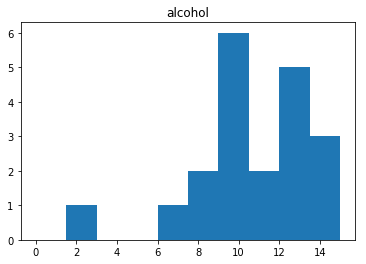

In [181]:
hist1 = df.loc[:, 'alcohol'].hist(grid=False, bins=10, range=(0,15))
hist1 = plt.title('alcohol')

On this histogram I can see one outlier where the yearly consumption fall far from the other values. I selected this country by value:

In [182]:
outlier_country = list(df.loc[df.loc[:,'alcohol'] < 5].index)
print('Possible utlier country based on alcohol consumption: ' + ', '.join(outlier_country))

Possible utlier country based on alcohol consumption: Turkey


I examined the three independent variable too the same way.

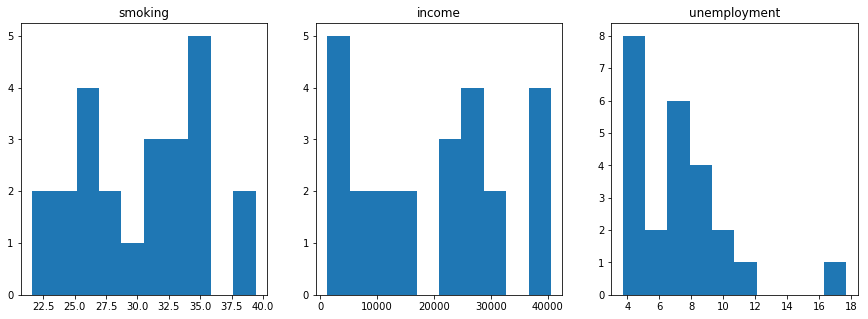

In [183]:
histogram_list = [[] for i in range(0, 3)]
plt.figure(figsize=(15,5))
for i in range(1, 4) :
    plt.subplot(1, 3, i)
    histogram_list[i-1] = df.loc[:, FILE_NAMES[i]].hist(grid=False)
    plt.title(FILE_NAMES[i])

In [184]:
smoking_outlier = list(df.loc[df.loc[:, 'smoking']>35].index)
print('Outlier countries based on smoking: ' + ', '.join(smoking_outlier))

Outlier countries based on smoking: Estonia, Latvia, Poland, Portugal, Turkey, United Kingdom


In [185]:
unemp_outlier = list(df.loc[df.loc[:, 'unemployment']>15].index)
print('Outlier countries based on unemployment ratio: ' + ', '.join(unemp_outlier))

Outlier countries based on unemployment ratio: Poland


Looking at the histogram, I didn't consider any country as possible outlier based on income.

I think these values don't seem to be invalid or erroneous so I decided to retain them in my analysis.

### General properties of dataset

After the initial cleaning step I calculated some basic statistics.

In [186]:
for field in ['alcohol', 'smoking', 'income', 'unemployment'] :
    (stat,pval) = sts.normaltest(df.loc[:, field].values)
    
    if pval < 0.05 :
        decision = 'rejected'
    else :
        decision = 'accepted'
        
    print('Normality of variable \'' + field + '\' is {} at 0.05 significance level.'.format(decision))

Normality of variable 'alcohol' is accepted at 0.05 significance level.
Normality of variable 'smoking' is accepted at 0.05 significance level.
Normality of variable 'income' is accepted at 0.05 significance level.
Normality of variable 'unemployment' is rejected at 0.05 significance level.


Based on statistical test I can state that alcohol consumption, smoking and income variables follow normal distribution (at 0.05 significance threshold), but unemployment ratio doesn't (maybe it follows a long tail distribution).
Below, I calculated some descriptive statistics for my dataset.

#### Mean

In [187]:
df.mean()

alcohol            11.455417
smoking            30.558333
income          19787.642021
unemployment        7.354167
dtype: float64

#### Standard deviation

In [188]:
df.std()

alcohol             3.185336
smoking             5.117652
income          12783.649880
unemployment        3.056281
dtype: float64

#### Median

In [189]:
df.median()

alcohol            12.060000
smoking            31.650000
income          23149.309243
unemployment        7.550000
dtype: float64

<a id="explore"></a>
## Exploratory analysis

Because I wanted to measure the connection between "high" alcohol consumption and the other 3 variables, I needed to define what "high" or "low" means.
From the normality test I could determine that alcohol consumption follows a normal distribution. Because of that, I created three groups:
 - average consumption (value in interval $[\mu - \sigma; \mu + \sigma]$
 - low consumption (value less than $\mu - \sigma$)
 - high consumption (value higher than $\mu + \sigma$)
 
To form these groups, I converted each value to z-value, then sorted values into different lists.

In [190]:
z_values = (df.loc[:, 'alcohol'] - df.loc[:, 'alcohol'].mean()) / df.loc[:, 'alcohol'].std()
countries_by_class = {}
countries_by_class['low'] = list(z_values.loc[z_values < -1].index)
countries_by_class['avg'] = list(z_values.loc[(-1 < z_values) & (z_values < 1)].index)
countries_by_class['high'] = list(z_values.loc[z_values > 1].index)

Result of grouping:

Countries with low alcohol consumption:
Japan, Norway, Philippines, Turkey

Countries with avg alcohol consumption:
Australia, Canada, Finland, France, Germany, Ireland, Latvia, Netherlands, New Zealand, Poland, Portugal, Spain, Sweden, Switzerland, United Kingdom, United States

Countries with high alcohol consumption:
Estonia, Lithuania, Romania, Slovenia



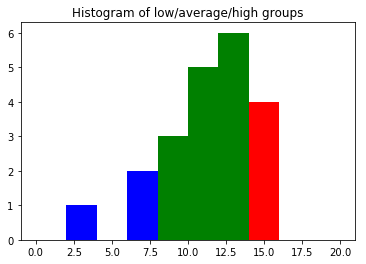

In [226]:
df_per_class = {}
for (group, members) in countries_by_class.items() :
    print('Countries with ' + group + ' alcohol consumption:\n{}'.format(', '.join(members)), end='\n\n')
    df_per_class[group] = df.loc[members]
    df_per_class[group].loc[:, 'alcohol'].hist(grid=False, bins=10, range=(0,20), color=level_colors[group])
    
plot_title = plt.title('Histogram of low/average/high groups')

### Question one: How does the economy of a country relate to alcohol consumption?

I decided that I will measure a country's economy by the combination of income per person and unemployment rate.

First, I want to decide if I need both variable for my analysis, or are they correlated so much that I could drop one of them? To answer this question, I calculate the correlation of the variables and perfom a PCA. Because I found that unemployment rate doesn't follow normal distribution, I can't use Pearson's R, but I have to use Spearman's $\rho$.

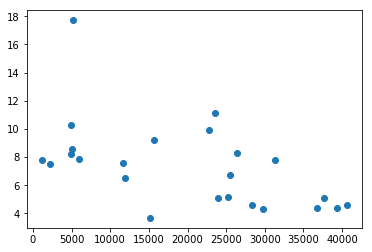

In [192]:
df_econ = df.loc[:, ['income', 'unemployment']]
scatter = plt.scatter(df_econ.iloc[:, 0], df_econ.iloc[:, 1])

In [231]:
(r, p) = sts.spearmanr(df_econ.iloc[:, 0], df_econ.iloc[:, 1])
print('r = {0:.3f} (p = {1:.3f})'.format(r, p))

r = -0.563 (p = 0.004)


From this result, I can see that income per person and unemployment rate are negatively correlated. It means that in countries with larger income the unemployment ratio is lower (which makes sense for me). The scatter plot above strengthen this finding.

Next step, I calculated the correlation of these two parameter with the alcohol consumption to decide if there is any linear dependence between any of them.

Correlation of alcohol vs. income: -0.327 (p=0.119)
Correlation of alcohol vs. unemployment: 0.218 (p=0.305)


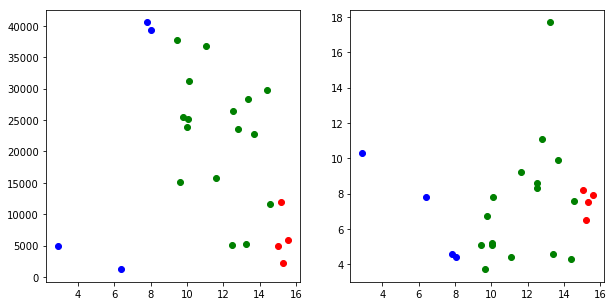

In [235]:
plt.figure(figsize=(10,5))
for group in levels :
    current_group = df.loc[countries_by_class[group]]
    plt.subplot(1, 2, 1)
    plt.plot(current_group.loc[:, 'alcohol'], current_group.loc[:, 'income'], 'o', color=level_colors[group])
    plt.subplot(1, 2, 2)
    plt.plot(current_group.loc[:, 'alcohol'], current_group.loc[:, 'unemployment'], 'o', color=level_colors[group])
    
(r, p) = sts.spearmanr(df.loc[:, 'alcohol'], df.loc[:, 'income'])
print('Correlation of alcohol vs. income: {0:.3f} (p={1:.3f})'.format(r, p))
(r, p) = sts.spearmanr(df.loc[:, 'alcohol'], df.loc[:, 'unemployment'])
print('Correlation of alcohol vs. unemployment: {0:.3f} (p={1:.3f})'.format(r, p))

The income and alcohol consumption shows a negative correlation, and we can see that on the first plot too. However, this correlation is not significant (at 0.05 significance level). In contrast, the unemployment rate shows a small positive correlation with the alcohol, but it isn't significant either. Finally, I draw a histogram of the distribution of income/unemployment within groups given by alcohol consumption level.

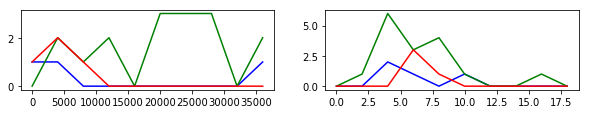

In [247]:
plt.figure(figsize=(10,5))
for group in levels :
    current_group = df.loc[countries_by_class[group]]
    plt.subplot(3, 2, 1);
    y, binedges = np.histogram(current_group.loc[:, 'income'], range=(0,40000), bins=10)
    plt.plot(binedges[:-1], y, color=level_colors[group])
    plt.subplot(3, 2, 2);
    y, binedges = np.histogram(current_group.loc[:, 'unemployment'], range=(0,20), bins=10)
    plt.plot(binedges[:-1], y, color=level_colors[group])

In [260]:
features = ['income', 'unemployment']
for f in range(0, 2) :
    for g1 in range(0, len(levels)-1) :
        group1_name = levels[g1]
        group1 = countries_by_class[group1_name]
        for g2 in range(g1+1, len(levels)) :
            group2_name = levels[g2]
            group2 = countries_by_class[group2_name]
            (t, p) = sts.ttest_ind(df.loc[group1, features[f]], df.loc[group2, features[f]])
            print('ttest: compare {3} between {0} & {1}: p = {2:.3f}'.format(group1_name, group2_name, p, features[f]))

ttest: compare income between low & avg: p = 0.859
ttest: compare income between low & high: p = 0.211
ttest: compare income between avg & high: p = 0.005
ttest: compare unemployment between low & avg: p = 0.726
ttest: compare unemployment between low & high: p = 0.625
ttest: compare unemployment between avg & high: p = 0.970


### Question two: Is there any connection between addiction to alcohol and tobacco?

### Question three: Where is Hungary - my home country - on these lists and what can we say about it compared to other countries?

<a id="discussion"></a>
## Discussion